## Import statements

In [1]:
import os
import sys 
import cv2
import time
import glob
import shutil
import pickle
import IPython
import fnmatch
import copyreg
import imagehash
from math import exp
from PIL import Image
import multiprocessing
from pprint import pprint
import concurrent.futures
from tqdm.notebook import tqdm

## Helper functions

In [2]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]


def thread_it(thread_function, my_list, tq=True, WORKERS=None):
    # Set worker number to CPU count
    if not WORKERS:
        WORKERS = multiprocessing.cpu_count()
    
    if tq:
        tq = tqdm(total=len(my_list))
    
    # Separate into chunks and execute threaded
    thread_list = chunks(my_list, WORKERS)
    for chunk in thread_list:
        with concurrent.futures.ThreadPoolExecutor(max_workers=WORKERS) as executor:
            for item in chunk:
                executor.submit(thread_function, item)
                if tq:
                    tq.update(1)
    tq.close()



def thread_it_return(thread_function, my_list, tq=True, WORKERS=None):
    # Set worker number to CPU count
    if not WORKERS:
        WORKERS = multiprocessing.cpu_count()
    
    if tq:
        tq = tqdm(total=len(my_list))
        
    results = []
    # Separate into chunks and execute threaded
    thread_list = chunks(my_list, WORKERS)
    for chunk in thread_list:
        with concurrent.futures.ThreadPoolExecutor(max_workers=WORKERS) as executor:
            for item in chunk:
                future = executor.submit(thread_function, item)
                
                return_value = future.result()
                if return_value != None:
                    results.append(return_value)
                    
                if tq:
                    tq.update(1)
    
    tq.close()
    
    return results
    

def show_img_by_path(a, resize=True, size=(320, 240)):
    # I could and probably need to implement image scaling beforehand, for network access
    img = Image.open(a)
    if resize:
        img = img.resize(size=size)
    IPython.display.display(img)


def create_folder(path):
    if not os.path.isdir(path):
        os.makedirs(path)

## Define various variables
#### This includes all paths for image folders.

In [3]:
# These should already exist from the "Download"
compare_dir = "compare_set/"
data_dir = "images/"


consider_dir = "consider/"
problems = "problems/"
blurry = "blurry/"

dirs = [consider_dir, blurry, problems]
for path in dirs:
    create_folder(path)

## Preprocessing

#### Get blur variance average for the comparison set

In [4]:
def blur_avg_thread(image):
    img = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    val = cv2.Laplacian(img, cv2.CV_64F).var()
    return val 

def get_blur_average(path, multiplier=1):
    files = glob.glob(path+"*.jpg", recursive=True)
    thr = thread_it_return(blur_avg_thread, files)
    avg = sum(thr) / len(files)
    return avg * multiplier

blur_avg = get_blur_average(compare_dir, multiplier=0.75)
print("The blur average is: ", blur_avg)


The blur average is:  2301.1319475837063



#### Get the images in the data set that are more blurry than a given threshold

In [5]:
def too_blurry_thread(item):
    image = item["image"]
    threshold = item["threshold"]
    img = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    val = cv2.Laplacian(img, cv2.CV_64F).var()
    if val < threshold:
        return image
                
def get_too_blurry(path, threshold):
    files = glob.glob(path+"*.jpg")
    items = []
    for image in files:
        items.append({"image": image, "threshold": threshold})
    too_blurry = thread_it_return(too_blurry_thread, items)
    
    print("{} out of {} images are blurry".format(len(too_blurry), len(files)))
    return too_blurry

#too_blurry = get_too_blurry(data_dir, blur_avg)
#https://www.pyimagesearch.com/2015/09/07/blur-detection-with-opencv/
# Temporary override to check how a constant of 200 does.
too_blurry = get_too_blurry(data_dir, 200)
# Well, it does pretty damn good!


0 out of 111 images are blurry


#### Remove the files referred to by the paths in the list

In [6]:
def move_to(file_list, dest):
    tq = tqdm(total=len(file_list))
    exception_flag = False
    for item in file_list:
        try:
            shutil.move(item, dest)
        except Exception as e:
            print(e)
            exception_flag = True
        tq.update(1)
    tq.close()
    return exception_flag

In [7]:
if move_to(too_blurry, blurry):
    del(too_blurry)

## Data processing
#### Hashing images

In [8]:
def hash_thread(image):
    fname = image.split(".")[-2]+".hsh"
    if not os.path.isfile(fname):
        img_hash = imagehash.dhash(Image.open(image))
        pickle.dump(img_hash, open(fname, "wb"))    

def compute_img_hashes(path):
    files = glob.glob(path+"*.jpg")
    thread_it(hash_thread, files)

compute_img_hashes(compare_dir)
compute_img_hashes(data_dir)


#### Compute hash distances for each image to each image

In [9]:
def hash_distance_thread(item):
    hash1 = pickle.load(open(item["hashname"], "rb"))
    dis = item["hashname"].split(".")[-2]+".dis"
    check = item["hashname"].split(".")[-2]+".jpg"
    
    if os.path.isfile(dis):
        compute = pickle.load(open(dis, "rb"))
    else:
        compute = {}
    
    for hashpath in item["files"]:
        try:
            image = hashpath.split(".")[-2]+".jpg"
            if image not in compute.keys() and image != check:
                hash2 = pickle.load(open(hashpath, "rb"))
                compute[image] = hash1 - hash2
        except Exception as e:
            print(e)
            
    pickle.dump(compute, open(dis, "wb"))

def compute_hash_distance(path):
    files = glob.glob(path+"*.hsh")
    
    items = []
    for image in files:
        items.append({"hashname": image, "files": files})

    thread_it(hash_distance_thread, items)

compute_hash_distance(compare_dir)    
compute_hash_distance(data_dir)

#### Check for duplicates

In [10]:
def get_duplicate_images(path, threshold=10):
    files = glob.glob(path+"*.dis")
    dup, close = [], []
    
    for path in files:
        distances = pickle.load(open(path, "rb"))
        img = path.split(".")[-2]+".jpg"
        
        for key, val in distances.items():
            if val == 0:
                if key not in dup and img not in dup:
                    dup.append(key)
            elif val < threshold:
                if key not in close and img not in close:
                    close.append(key)
                
    return dup, close

compare_dup, compare_close = get_duplicate_images(compare_dir, threshold=5)
data_dup, data_close = get_duplicate_images(data_dir, threshold=5)

print("Compare duplicates:")
pprint(compare_dup)
print("Compare close:")
pprint(compare_close)

print("Data duplicates:")
pprint(data_dup)
print("Data close:")
pprint(data_close)

show = False
if show:
    print("DUPLICATES IN COMPARE:")
    for item in compare_dup:
        show_img_by_path(item)
    print("DUPLICATES IN DATA:")
    for item in data_dup:
        show_img_by_path(item)
    print("CLOSE IN COMPARE:")
    for item in compare_close:
        show_img_by_path(item)
    print("CLOSE IN DATA:")
    for item in data_close:
        show_img_by_path(item)

Compare duplicates:
[]
Compare close:
[]
Data duplicates:
[]
Data close:
[]


#### Remove duplicates

In [11]:
if move_to(compare_dup, problems):
    del(compare_dup)
if move_to(data_dup, problems):
    del(data_dup)

## Feature Extraction

In [12]:
# Register Pickle behaviour for feature points.
def _pickle_keypoints(point):
    return cv2.KeyPoint, (*point.pt, point.size, point.angle,
                          point.response, point.octave, point.class_id)

# Register pickle handler for KeyPoints
copyreg.pickle(cv2.KeyPoint().__class__, _pickle_keypoints)

In [13]:
def extract_thread(item):
    image = item["image"]
    points = image.split(".")[-2]+".pts"
    detector = item["detector"]

    if not os.path.isfile(points):
        try:
            img = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
            kp, des = detector.detectAndCompute(img, None)
            data = {"kp": kp, "des": des}
            pickle.dump(data, open(points, "wb"))
        except Exception as e:
            print("{} failed because {}".format(image, e))

def feature_extraction(path, feature_detector="ORB", points_num=8192):
    # Get all images list.
    files = glob.glob(path+"*.jpg")

    detector = None
    if feature_detector == "SIFT":
        detector = cv2.SIFT_create(nfeatures=points_num)
    elif feature_detector == "SURF":
        detector = cv2.SURF_create(nfeatures=points_num)
    elif feature_detector == "ORB":
        # This is NOT scale-invariant, ughhh.
        detector = cv2.ORB_create(nfeatures=points_num)
    elif feature_detector == "AKAZE":
        detector = cv2.AKAZE_create()

    print("Detector used:", detector)
        
    items = []
    for image in files:
        items.append({"image": image, "detector": detector})
    
    thread_it(extract_thread, items)

In [14]:
points_num = 2048
features = "AKAZE"
feature_extraction(compare_dir, feature_detector=features, points_num=points_num)
feature_extraction(data_dir, feature_detector=features, points_num=points_num)

Detector used: &lt;AKAZE 0x7fea2c4fc810&gt;



Detector used: &lt;AKAZE 0x7fea2c586dd0&gt;


## Feature Matching

In [15]:
def get_matcher(feature_detector="AKAZE", bf_or_flann="BF"):
    #https://www.programcreek.com/python/?code=NetEase%2Fairtest%2Fairtest-master%2Fairtest%2Ftrash%2Ffind_obj.py
    matcher, norm = None, None
    if feature_detector in ["ORB", "AKAZE"]:
        norm = cv2.NORM_HAMMING
    elif feature_detector in ["SIFT", "SURF"]:
        norm = cv2.NORM_L2
    if bf_or_flann == "FLANN":
        if norm == cv2.NORM_L2:
            FLANN_INDEX_KDTREE = 1
            flann_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        else:
            FLANN_INDEX_LSH = 6
            flann_params= dict(algorithm = FLANN_INDEX_LSH,
                                table_number = 6, # 12
                                key_size = 12,     # 20
                                multi_probe_level = 1) #2
        matcher = cv2.FlannBasedMatcher(flann_params, {})
        # bug : need to pass empty dict (#1329)
    elif bf_or_flann == "BF":
        matcher = cv2.BFMatcher(norm)
    else:
        matcher = cv2.BFMatcher(norm)

    return matcher


def match_within_path(path, matcher, ratio_test=False):
    files = glob.glob(path+"*.jpg")
    
    tq = tqdm(total=len(files))
    for img1 in files:
        base1 = img1.split(".")[-2]
        jpg1 = base1+".jpg"
        features1 = pickle.load(open(base1+".pts", "rb"))
        
        if os.path.isfile(base1+".mch"):
            matches1 = pickle.load(open(base1+".mch", "rb"))
        else:
            matches1 = {}
            
        for img2 in files:
            # Skip if same image
            if img1 is img2:
                continue
            
            base2 = img2.split(".")[-2]
            jpg2 = base2+".jpg"
            features2 = pickle.load(open(base2+".pts", "rb"))
            
            # If either were matched against the other, fill out and skip
            if os.path.isfile(base2+".mch"):
                matches2 = pickle.load(open(base2+".mch", "rb"))
                if jpg1 in matches2.keys():
                    matches1[jpg2] = matches2[jpg1]
                    continue
                elif jpg2 in matches1.keys():
                    matches2[jpg1] = matches1[jpg2]
                    continue
            else:
                matches2 = {}

            # Read computed data.
            des1 = features1["des"]  # Actual set image
            des2 = features2["des"]  # Compare set image
            try:
                matches_data = matcher.knnMatch(des1, des2, k=2)
            except Exception as e:
                print(e)
                matches_data = []

            if ratio_test:
                # Apply ratio test
                good = []
                for m, n in matches_data:
                    if m.distance < 0.75*n.distance:
                        good.append(True)

                matches1[jpg2] = len(good)
                matches2[jpg1] = len(good)
            else:
                # Those that don't exist in here probably don't have matches can be removed
                matches1[jpg2] = len(matches_data)
                matches2[jpg1] = len(matches_data)

            pickle.dump(matches2, open(base2+".mch", "wb"))
        pickle.dump(matches1, open(base1+".mch", "wb"))
        tq.update(1)


def match_features_other_path(path, other_path, matcher, ratio_test=False):
    # Get pre-computed images list.
    files = glob.glob(path+"*.pts")
    other = glob.glob(other_path+"*.pts")

    tq = tqdm(total=len(files))
    for img1 in files:
        base1 = img1.split(".")[-2]
        jpg1 = base1+".jpg"
        
        features1 = pickle.load(open(base1+".pts", "rb"))
        if os.path.isfile(base1+".mch"):
            matches = pickle.load(open(base1+".mch", "rb"))
        else:
            matches = {}
            
        for img2 in other:
            # Skip if same image
            if img1 is img2:
                continue
            
            base2 = img2.split(".")[-2]
            jpg2 = base2+".jpg"
            
            if jpg2 in matches.keys():
                continue
            
            features2 = pickle.load(open(base2+".pts", "rb"))

            # Read computed data.
            des1 = features1["des"]  # Actual set image
            des2 = features2["des"]  # Compare set image
            try:
                matches_data = matcher.knnMatch(des1, des2, k=2)
            except Exception:
                matches_data = []

            if ratio_test:
                # Apply ratio test
                good = []
                for m, n in matches_data:
                    if m.distance < 0.75*n.distance:
                        good.append(True)
                        
                matches[jpg2] = len(good)
            else:
                # Those that don't exist in here probably don't have matches can be removed
                matches[jpg2] = len(matches_data)
        tq.update(1)
                

        pickle.dump(matches, open(base1+".mch", "wb"))

In [16]:
matcher = get_matcher(feature_detector=features, bf_or_flann="BF") # Normally using BF, but, let's try FLANN
print(matcher)

match_within_path(compare_dir, matcher, ratio_test=True)
match_features_other_path(data_dir, compare_dir, matcher, ratio_test=True)

&lt;BFMatcher 0x7fea26d9dcd0&gt;


In [17]:
def load_and_total_matches(path):
    files = glob.glob(path+"*.jpg")
    matches = {}
    for path in files:
        match_path = path.split(".")[-2]+".mch"
        matches[path] = pickle.load(open(match_path, "rb"))
    return matches

compare_matches = load_and_total_matches(compare_dir)
data_matches = load_and_total_matches(data_dir)

pprint(data_matches)


                                                      &#39;compare_set/image_4d319f3fcf359a10e879de21c93571ce.jpg&#39;: 32,
                                                       &#39;compare_set/image_6fb83397635551df36d4192de4129e9a.jpg&#39;: 33},
 &#39;images/image_fb74f2f94e1e26a2cb65cd147bb10a58.jpg&#39;: {&#39;compare_set/image_0a267444ea542710f6d1261aec4cdede.jpg&#39;: 7,
                                                       &#39;compare_set/image_0b74808c6f93d3eaa36d973a8aadb336.jpg&#39;: 2,
                                                       &#39;compare_set/image_0ef489424c1de58a34d126b3780deb5a.jpg&#39;: 9,
                                                       &#39;compare_set/image_3f656bb20e156a03f5ab848718a08c84.jpg&#39;: 8,
                                                       &#39;compare_set/image_4d319f3fcf359a10e879de21c93571ce.jpg&#39;: 5,
                                                       &#39;compare_set/image_6fb83397635551df36d4192de4129e9a.jpg&#39;: 5

COMPARISON SET:


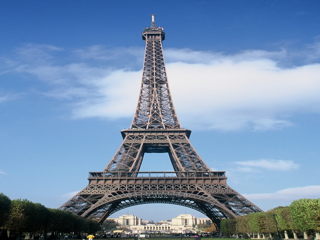

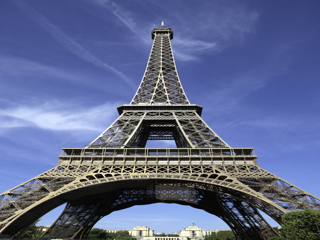

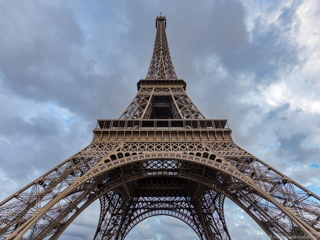

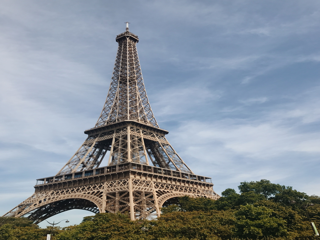

e.jpg&#39;: 58,
 &#39;compare_set/image_0b74808c6f93d3eaa36d973a8aadb336.jpg&#39;: 64,
 &#39;compare_set/image_0ef489424c1de58a34d126b3780deb5a.jpg&#39;: 66,
 &#39;compare_set/image_3f656bb20e156a03f5ab848718a08c84.jpg&#39;: 76,
 &#39;compare_set/image_4d319f3fcf359a10e879de21c93571ce.jpg&#39;: 56,
 &#39;compare_set/image_6fb83397635551df36d4192de4129e9a.jpg&#39;: 41}
{&#39;compare_set/image_0a267444ea542710f6d1261aec4cdede.jpg&#39;: 121,
 &#39;compare_set/image_0b74808c6f93d3eaa36d973a8aadb336.jpg&#39;: 98,
 &#39;compare_set/image_0ef489424c1de58a34d126b3780deb5a.jpg&#39;: 148,
 &#39;compare_set/image_3f656bb20e156a03f5ab848718a08c84.jpg&#39;: 130,
 &#39;compare_set/image_4d319f3fcf359a10e879de21c93571ce.jpg&#39;: 89,
 &#39;compare_set/image_6fb83397635551df36d4192de4129e9a.jpg&#39;: 127}
{&#39;compare_set/image_0a267444ea542710f6d1261aec4cdede.jpg&#39;: 24,
 &#39;compare_set/image_0b74808c6f93d3eaa36d973a8aadb336.jpg&#39;: 35,
 &#39;compare_set/image_0ef489424c1de58a34d126b3780deb5a.

In [18]:
print("COMPARISON SET:")

show_img_by_path('compare_set/image_0b74808c6f93d3eaa36d973a8aadb336.jpg')
show_img_by_path('compare_set/image_0ef489424c1de58a34d126b3780deb5a.jpg')
show_img_by_path('compare_set/image_4d319f3fcf359a10e879de21c93571ce.jpg')
show_img_by_path('compare_set/image_6fb83397635551df36d4192de4129e9a.jpg')

print("DATASET:")
for key, val in data_matches.items():
    #show_img_by_path(key)
    pprint(val)

In [19]:
def total_matches(matches, do_print=False):
    totals = {}
    for key in matches.keys():
        totals[key] = []
    for key, value in matches.items():
        length = len(value)
        for _, num_matches in value.items():
            totals[key].append(num_matches)
    for key in totals.keys():
        totals[key] = sum(totals[key])

    if do_print:
        pprint(totals)
    return totals

compare_total_matches = total_matches(compare_matches)
data_total_matches = total_matches(data_matches)

pprint(compare_total_matches)
pprint(data_total_matches)

{&#39;compare_set/image_0a267444ea542710f6d1261aec4cdede.jpg&#39;: 227,
 &#39;compare_set/image_0b74808c6f93d3eaa36d973a8aadb336.jpg&#39;: 190,
 &#39;compare_set/image_0ef489424c1de58a34d126b3780deb5a.jpg&#39;: 385,
 &#39;compare_set/image_3f656bb20e156a03f5ab848718a08c84.jpg&#39;: 391,
 &#39;compare_set/image_4d319f3fcf359a10e879de21c93571ce.jpg&#39;: 339,
 &#39;compare_set/image_6fb83397635551df36d4192de4129e9a.jpg&#39;: 828}
{&#39;images/image_0b45d7535953e96c1697f889ff4e3563.jpg&#39;: 95,
 &#39;images/image_0b7d37457e33ed0c35317108ba022b1d.jpg&#39;: 128,
 &#39;images/image_0bc9f18ce5bc85ef631b19db6dbe7b3e.jpg&#39;: 1777,
 &#39;images/image_0ca1ec357831bdcae715a0ced23cd4fb.jpg&#39;: 126,
 &#39;images/image_0e68be35e362040cdc7d8563bf73c634.jpg&#39;: 243,
 &#39;images/image_0fe033246e4325a9017c6db46846476f.jpg&#39;: 679,
 &#39;images/image_1a20120b62d7cdd1fd3cd9f8fd1aa9b9.jpg&#39;: 521,
 &#39;images/image_1e3a4380df61c5c05156d45e56b722c4.jpg&#39;: 118,
 &#39;images/image_2ad94d93fee5f

## Calculate threshold from comparison set 

In [20]:
def get_thr_from_compare(path, totals, multipler=1):
    thr_per_image = {}
    
    tq = tqdm(total=len(totals))
    for img1, item in totals.items():
        for img2, val in item.items():
            # Actual resolutions differences won't matter when using Scale-Invariant feature descriptions
            # Only do multipler because references are the best case, real data won't be.
            thr = val * multipler
            
            # Add thr to dict
            if img2 not in thr_per_image.keys():
                thr_per_image[img2] = [thr]
            else:
                thr_per_image[img2].append(thr)
        tq.update(1)

    # Get the average feature match for a valid image for each image in the reference set to every other image
    for key in thr_per_image.keys():
        val = thr_per_image[key]
        thr_per_image[key] = sum(val)/len(val)
        
    return thr_per_image

In [21]:
# Does Lowe ratio apply here?
#thr = thr*0.75

thr_per_image = get_thr_from_compare(compare_dir, compare_matches, multipler=0.85)
pprint(thr_per_image)


{&#39;compare_set/image_0a267444ea542710f6d1261aec4cdede.jpg&#39;: 38.589999999999996,
 &#39;compare_set/image_0b74808c6f93d3eaa36d973a8aadb336.jpg&#39;: 32.3,
 &#39;compare_set/image_0ef489424c1de58a34d126b3780deb5a.jpg&#39;: 65.44999999999999,
 &#39;compare_set/image_3f656bb20e156a03f5ab848718a08c84.jpg&#39;: 66.47,
 &#39;compare_set/image_4d319f3fcf359a10e879de21c93571ce.jpg&#39;: 57.629999999999995,
 &#39;compare_set/image_6fb83397635551df36d4192de4129e9a.jpg&#39;: 140.76}


## Apply threshold to data directory set

In [22]:
def get_threshold_items(totals, thr_per_image, show=False):
    values = {}
    #x, y = [], []
    tq = tqdm(total=len(totals))
    for img1, item in totals.items():
        # Get resolution
        img = cv2.imread(img1, cv2.IMREAD_GRAYSCALE)
        height, width = img.shape
        res = width * height

        rating = 0
        
        for img2, val in item.items():
            # If the "Data" image is under the thr for the comparison image
            if val > thr_per_image[img2]:
                # Show which images from the comparison set, the data image is under thr for, and how much
                rating += 1
                
        rating = rating / len(item) 
        #rating = sigmoid(rating)

        values[img1] = rating
        
        tq.update(1)
    """    
    if show:
        %matplotlib notebook
        import matplotlib.pyplot as plt
        plt.figure(figsize=(200, 200))
        plt.plot(y, x, "o", color="black")
        plt.plot([x for x in range(len(x))], [confidence for x in range(len(x))], '-ok', color="red")
        plt.xlabel("Number of features")
        plt.ylabel("Confidence")
        plt.show()
        print("Average is ", confidence)
    """
        
    return values

In [26]:
ratings = get_threshold_items(data_matches, thr_per_image, show=False)
#pprint(ratings)

under_confidence = []
confidence = sum(ratings.values()) / len(ratings)
print("CONFIDENCE: {}".format(confidence))
for key, val in ratings.items():
    if val < confidence:
        print(key, "@", val)
        under_confidence.append(key)
        show_img_by_path(key, size=(75,75))

AttributeError: &#39;NoneType&#39; object has no attribute &#39;shape&#39;

In [24]:
def move_threshold_items(under, consider_folder, do_print=False):
    for val in under:
        if os.path.isfile(val):
            filename = val.split("/")[-1]
            path = os.path.join(consider_folder, filename)
            try:
                shutil.move(val, consider_folder)
            except Exception as e:
                print(e)
        else:
            print(val, "doesn't exist")

move_threshold_items(under_confidence, consider_dir)

# An idea; I could possibly smush all the feature data for the comparison images into one object... That would give me a nice percentage as an overall match.